
# Homework 2

## [Hongwei Zha] - [hz2816]

### Due: Fri Mar 11th @ 11:59pm ET

In this homework we will be performing model evaluation, model selection and hyperparameter tuning in both a regression and classification setting.

We will be working with a small set of home sales data as we might see on a real-estate website.


## Instructions

- Replace Name and UNI in the first cell and filename with your UNI and name.
- Follow the comments below and fill in the blanks (____) to complete.
- Where a text response is asked for, please enter as a comment, starting each line with #.


Out of 50 points total.

## Part 0: Environment Setup

In [2]:
# 1. (2pts) Set up our environment with common libraries and plot settings.
#    Note: generally we would do all of our imports here but some imports
#    have been left till later where they are used.

# Import numpy as np, pandas as pd, matplotlib.pyplot as plt and seaborn as sns
# Note: use as many lines of code as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style to 'darkgrid'
sns.set_style('darkgrid')

# Execute the matplotlib magic function to ensure plots are displayed inline
%matplotlib inline

## Part 1: Regression

In Part 1 we will try to predict a real value home sale price using several models.

<AxesSubplot:xlabel='AdjSalePrice', ylabel='Count'>

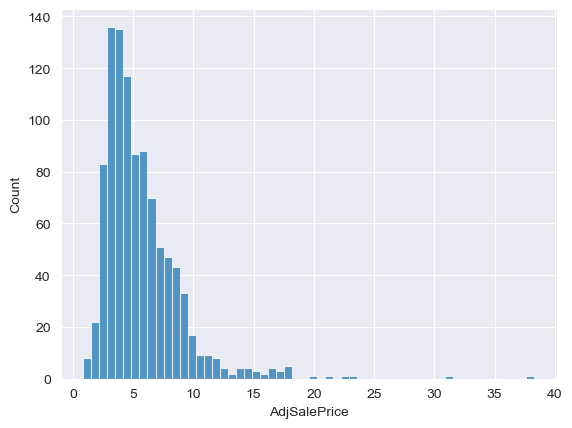

In [67]:
# 2. (4pts) Load and prepare our data.

# Read in the csv file ../data/house_sales_subset.csv using pandas read_csv() with default parameter settings
df = pd.read_csv("C:/Users/zha/Downloads/house_sales_subset.csv")

# Create a dataframe X which contains these 3 columns from df:
#  'SqFtTotLiving_x1000','SqFtLot_x1000','Bedrooms'
X = df.loc[:999,['SqFtTotLiving']] / 1000
X = X.rename(columns = {'SqFtTotLiving':'SqFtTotLiving_x1000'})
X['SqFtLot_x1000'] = df.loc[:999,['SqFtLot']] / 1000
X['Bedrooms'] = df.loc[:999,['Bedrooms']]

# Create a series y_r which contains only the column AdjSalePrice_x100000
#    Note: the '_r' is for our regression target
y_r = df.loc[:999,'AdjSalePrice'] / 100000

# Check that X and y_r is the correct shape
assert X.shape == (1000,3)
assert y_r.shape == (1000,)

# To confirm that all features of X are similar in scale display the .describe() of X
X.describe()

# To get a sense of the distribution of the target, plot a histogram of y_r using sns.histplot()
sns.histplot(y_r)

In [4]:
# 3. (3pts) Create a held-aside set

# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split X and y_r into 80% train and 20% test using train_test_split
#   Use random_state=123 for grading consistency.
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_r, train_size = 0.8, random_state = 123)

# Print out the the length of y_test_r divided by the length y_r  to confirm our test set size.
print(f'proportion of data in test set: {len(y_test_r) / len(y_r):0.2f}')

proportion of data in test set: 0.20


### Part 1.1 Baseline Regressor

In [6]:
# 4. (3pts) Create a DummyRegressor and fit on the training set.

# Import the DummyRegressor model from sklearn 
from sklearn.dummy import DummyRegressor

# Instantiate a DummyRegessor model with strategy="mean" 
dummy_r = DummyRegressor(strategy = "mean")

# Train the DummyRegressor on the regression training set
dummy_r.fit(X_train_r, y_train_r)

# Calculate and print the training set R^2 score of the DummyRegressor
dummy_r_training_r2 = dummy_r.score(X_train_r, y_train_r)

print(f'dummy training set R^2: {dummy_r_training_r2:.2f}')

dummy training set R^2: 0.00


### Part 1.2 Linear Regression and Cross-Validation

In [8]:
# 5. (4pts) Train a Linear Regression model and calculate training set R^2.

# Import the LinearRegression model from sklearn
from sklearn.linear_model import LinearRegression

# Instantiate a LinearRegression model with default arguments and fit on the training set
lr = LinearRegression()
lr.fit(X_train_r, y_train_r)

# Calculate and print the training set R^2 of the LinearRegression model
lr_training_r2 = lr.score(X_train_r, y_train_r)

print(f'lr training set R^2: {lr_training_r2:.2f}')

lr training set R^2: 0.57


In [9]:
# 6. (2pts) Use 5-fold Cross Validation to get a sense of variation 
#    of Liner Regression R^2 performance on the training set.

# Import cross_val_score from sklearn.
from sklearn.model_selection import cross_val_score

# Generate 5-fold cross-validation R^2 scores 
#    for a LinearRegression model with default arguments 
#    on the training set
lr_cv_scores = cross_val_score(lr, X_train_r, y_train_r, cv = 5)

# Print out the R^2 scores found by cross_val_score
np.round(lr_cv_scores,2)

array([0.51, 0.58, 0.6 , 0.51, 0.55])

In [10]:
# 7. (1pts) Calculate mean cv R^2 score +- 2 std. deviations

# Calculate the mean cross validation score using the scores created above
lr_cv_mean = np.mean(lr_cv_scores)

# Calculate 2 standard deviations of the cross validation scores
lr_cv_2std = 2 * np.std(lr_cv_scores)

# Print out the mean R^2 +- 2 standard variations for the LinearRegression model
print(f'lr mean cv r2: {lr_cv_mean:.2f} +- {lr_cv_2std:.2f}')

lr mean cv r2: 0.55 +- 0.07


### Part 1.3 Evaluate on Test Set

In [11]:
# 8. (2pts) Evaluate performance of our trained DummyRegressor and LinearRegression model on the test set.

# Calculate R^2 on the test set using the previously trained models
dummy_r_test_r2 = dummy_r.score(X_test_r, y_test_r)

lr_test_r2 = lr.score(X_test_r, y_test_r)

print(f'dummy test R2 : {dummy_r_test_r2: .2f}')
print(f'   lr test R2 : {lr_test_r2: .2f}')

dummy test R2 : -0.01
   lr test R2 :  0.60


---

## Part 2: Classification

Here we build several models to classify low vs. high adjusted sales price, creating a validation curve and performing grid search.

### Create Classification Target

In [17]:
# To reuse the same dataset, we'll first create a binary target for 
#    classification by thresholding at the mean of our AdjSalePrice

# The classes are:
#    Low AdjSalePrice  = 0
#    High AdjSalePrice = 1

y_c = (df.AdjSalePrice > df.AdjSalePrice.mean()).astype(int)[:1000]

# Print out the unique labels and note it's 0,1 or binary classification
y_c.unique()

array([0, 1])

### Part 2.1 Create a Held-Aside Aet

In [21]:
# 9. (3pts) Create a training and test/held-aside set

# Split into 80% train and 20% test using train_test_split 
#    Use the new y_c target and the same X we used for regression
#    Stratify according to y_c so class proportions are the same in train and test
#    Use random_state=123 for reproducibility
#    Save the result into the variables X_train_c,X_test_c,y_train_c,y_test_c
X_train_c,X_test_c,y_train_c,y_test_c = train_test_split(X, y_c, train_size = 0.8, random_state = 123, stratify = y_c)

# Print out the proportion of Low values (label of 0) in y_c
print(f'proportion of low values: {1-np.mean(y_c):0.2f}')

# Assert that train and test have similar class proportions.
# Find the proportion of Low (0) values in both y_train_c and y_test_c and 
#    assert that the absolute difference of these proportions is less than .01
assert np.abs(np.mean(y_train_c)-np.mean(y_test_c)) < 0.01

proportion of low values: 0.60


### Part 2.2 Measure baseline performance

In [22]:
# 10. (2pts)  Create a Dummy Classifier and confirm the expected performance on the training set.

# Import DummyClassifier from sklearn
from sklearn.dummy import DummyClassifier

# Instantiate and a DummyClassifier with strategy="most_frequent" and fit on the the training set
dummy_c = DummyClassifier(strategy="most_frequent")
dummy_c.fit(X_train_c, y_train_c)

# Print the trained DummyClassifier accuracy on the training set.
# It should match the proportion of low values we saw above.
print(f'dummy training set accuracy: {dummy_c.score(X_train_c, y_train_c):.2f}')

dummy training set accuracy: 0.60


### Part 2.3  Logistic Regression model

In [56]:
# 11. (3pts) It's good practice to start with a "simple" model.
#     Train and calculate 5-fold cv training set accuracy for a Logistic Regression Classifier.

# Import LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Generate 5-fold cross validation accuracy on the training set
#    using LogisticRegression with default hyperparameters
#    store as logr_cvscores
logr_cv_scores = cross_val_score(LogisticRegression(),X_train_c,y_train_c)

# Print out the mean cv accuracy for the LogisticRegression model
print(f'logr mean cv accuracy: {np.mean(logr_cv_scores):0.2f}')

logr mean cv accuracy: 0.83


### Part 2.4 GradientBoosting model

In [24]:
# 12. (4pts) Now let's try a more complex model.
#     Train and calculate 5-fold cv accuracy 
#     for a GradientBoosting model using the training set.

# Import the GradientBoostingClassifier model from sklearn
from sklearn.ensemble import GradientBoostingClassifier

# Calculate 5-fold cv training set accuracy scores for a GradientBoostingClassifier
#   with 50 trees and max_depth=2
#   To speed up training also set n_jobs=-1 in the cross_val_score (use one core for each fold)
gbc_cv_scores = cross_val_score(GradientBoostingClassifier(n_estimators = 50, max_depth=2),X_train_c,y_train_c, n_jobs = -1)
 
# Calculate mean cv accuracy
gbc_cv_mean = np.mean(gbc_cv_scores)

# Calculate 2 standard deviations for the cv scores
gbc_cv_2std = 2*np.std(gbc_cv_scores)

print(f'gbc mean cv accuracy: {gbc_cv_mean:.2f} +- {gbc_cv_2std:.2f}')

gbc mean cv accuracy: 0.83 +- 0.06


### Part 2.5 GradientBoosting and Validation Curve

In [31]:
# 13. (5pts) Let's investigate how the depth of trees (max_depth) affects performance.
#     Generate a validation curve for tree depths in the GradientBoosting model.

# Import the validation_curve function from sklearn
from sklearn.model_selection import validation_curve

# In the GradientBoostingClassifier model, the depth of trees is set via max_depth
# Here we'll try the depths 1,2,3,5,10
depths = [1,2,3,5,10]

# Generate the train_scores and test_scores for max_depth at different max_depths
#   Use the validation_curve function
#   Use a GradientBoostingClassiier with 50 trees
#   Use our training set X_train_c, y_train_c
#   Use the 'max_depth' parameter
#   Use the depths list created above as the parameter range
#   Use 3-fold cross validation (reducing to 3 to speed things up)
#   Use accuracy as the scoring metric
#   Store the results in train_scores,test_scores
train_scores,test_scores = validation_curve(
    GradientBoostingClassifier(n_estimators = 50, max_depth=depths),
    X_train_c,
    y_train_c,
    param_name="max_depth",
    param_range=depths,
    cv = 3,
    scoring="accuracy",
)

# train_scores and test_scores each contain a 2-D array of values
#   For each depth (rows) there are 3 scores (columns), one for each fold
#   Take the mean for each depth across folds (columns, axis=1) 
#      and store in mean_train_scores and mean_test_scores
mean_train_scores = np.mean(train_scores, axis = 1)
mean_test_scores = np.mean(test_scores, axis = 1)

# We should get 10 values between 0 and 1
# Note that as depth increases, both train and test accuracy go up and then begin to diverge
pd.DataFrame([mean_train_scores.round(2),mean_test_scores.round(2)],
             columns=pd.Series(depths,name='max_depth'),
             index=['mean_train_scores','mean_test_scores'])

max_depth,1,2,3,5,10
mean_train_scores,0.83,0.85,0.89,0.97,0.99
mean_test_scores,0.82,0.83,0.83,0.82,0.79


Text(0, 0.5, 'mean accuracy')

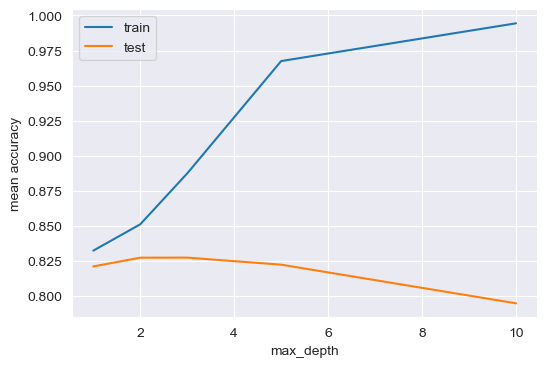

In [45]:
# 14. (4pts) Plot the validation curve

# Plot mean_train_scores and mean_test_scores on the same plot
#    create an axis to plot on using subplots, with figsize=(6,4)
#    plot two lines using ax.plot()
#      each with "depths" on the x-axis
#      one for mean_train_scores on the y-axis with label "train"
#      one for mean_test_scores on the y-axis with label "test"
#    add a legend using ax.legend()
#    label the x-axis as "max_depth" and the y-axis as "mean accuracy"
# Note: use as many lines of code as necessary
fig, ax = plt.subplots(figsize = (6,4))
ax.plot(depths, mean_train_scores, label = "train")
ax.plot(depths, mean_test_scores, label = "test")
ax.legend()
plt.xlabel("max_depth")
plt.ylabel("mean accuracy")

### Part 2.6 GradientBoosting and Grid Search

In [55]:
# 15. (4pts) Above we're looking at tuning a single hyperparameter (max_depth).
#     Now let's tune two hyperparameters at the same time.
#     Perform 3-fold cross validated grid search over number of trees and tree depth.

# Import GridSearchCV from sklearn
from sklearn.model_selection import GridSearchCV

# Create the grid of parameters to test
#   The parameter settings to try are 
#   'n_estimators':[10,50,100,200],'max_depth':[1,2,3,5,10]
params = {'n_estimators':[10,50,100,200],
           'max_depth':[1,2,3,5,10]}

# Instantiate and fit GridSearchCV on the classification training set
#   Use GradientBoostingClassifier with default arguments 
#   Use 3-folds
#   Use default scoring (accuracy)
#   Use refit=True (default) so the model is retrained on the entire training set
#   Set n_jobs=-1 to use all cores
gbc_gscv = GridSearchCV(GradientBoostingClassifier(),
                    param_grid=params,     
                    cv=3,       
                    scoring = "accuracy",
                    refit=True,
                    n_jobs = -1) 
gbc_gscv.fit(X_train_c,y_train_c)

# Print out the best the best hyperparameter setting found (best_params_) 
#    and the mean accuracy they produced (best_score_)
print(f'gbc best hyperparams      : {gbc_gscv.best_params_}')
print(f'gbc best mean cv accuracy : {gbc_gscv.best_score_:.2f}')
# Note that you may get different answers on different runs due to 
#   the random cv splits used at each grid point

gbc best hyperparams      : {'max_depth': 3, 'n_estimators': 100}
gbc best mean cv accuracy : 0.84


### Part 2.7 Evaluate on Test

In [60]:
# 16. (4pts) Evaluate the best model on the test set

# Which of our models has the highest training set cv accuracy?
#   (GradientBoostingClassifier or LogisticRegression?)
print('best model found: GradientBoostingClassifier ')

# To see how each of our models would generalize to new data,
#     calculate the **test set** accuracy for each of our trained models

# First, instantiate and train a new LogisticRegression model with default settings on the training set.
# Note that, while we did train a LogisticRegression model several times when 
#  calculating the cross-validation accuracy, we never trained it on the full training set
logr = LogisticRegression().fit(X_train_c, y_train_c)

# Find the test set accuracy of both of our trained models
# Recall that since we used refit=True when doing grid search
#  on the GradientBoostingClassifier, we can use gbc_gscv.score() without retraining
logr_test_acc = logr.score(X_test_c, y_test_c)
gbc_test_acc = gbc_gscv.score(X_test_c, y_test_c)

print(f'logr test acc : {logr_test_acc:.2f}')
print(f'gbc  test acc : {gbc_test_acc:.2f}')

# TO THINK ABOUT, BUT DON'T NEED TO ANSWER:
# Did the model we chose have the best test set performance?
# Is it guaranteed that the model with the best cv scores on the training set has the best test set score?

best model found: GradientBoostingClassifier 
logr test acc : 0.84
gbc  test acc : 0.83
